## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def draw_chessboard_corners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow("img", img)
            cv2.waitKey(500)
    cv2.destroyAllWindows()


def calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    res, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return res, mtx, dist

In [2]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
res, mtx, dist = calibration_mtx()

# Store coefficients in order to use it from tests notebooks
import pickle

data = {
    'mtx': mtx,
    'dist': dist
}

with open('calibration.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


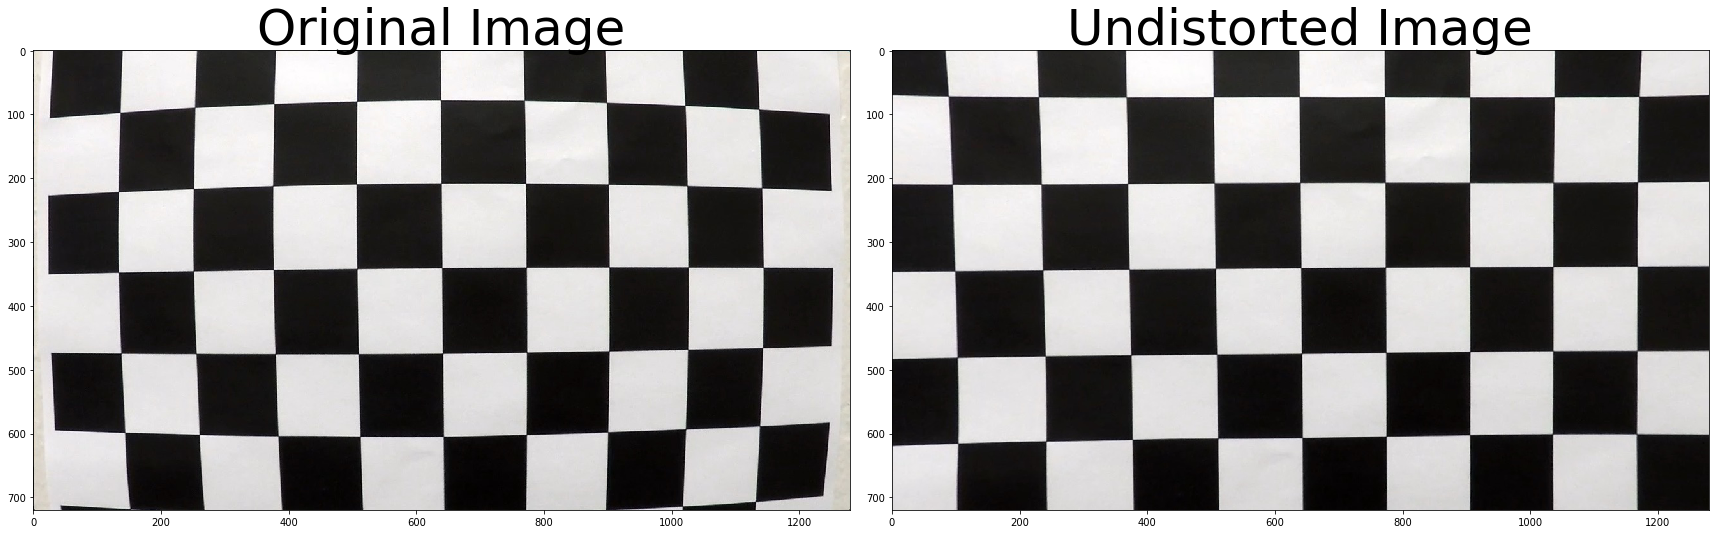

In [3]:
img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted = undistort_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
f.show()

## And so on and so forth...

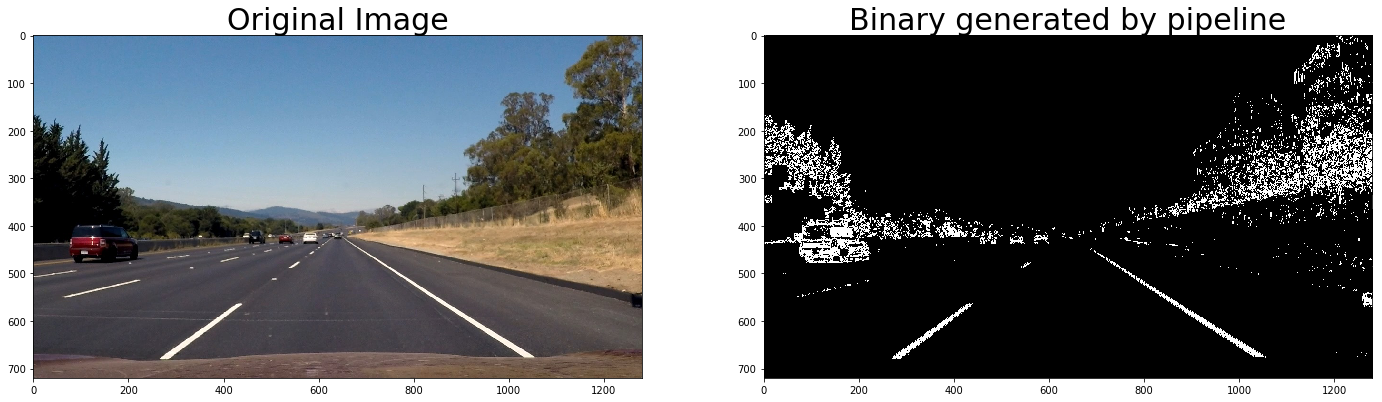

In [4]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), dir_thresh=(0.7, 1.3)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]

    abs_sobelx = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=3))        
#    abs_sobely = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=3))
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
#    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
#    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    binary = np.zeros_like(scaled_sobelx)
    
    binary[
        ((scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])) |
        ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]))
    ] = 1
    
    return binary

image = mpimg.imread('test_images/straight_lines2.jpg')
f, ax = plt.subplots(1, 2, figsize=(24, 9))
ax[0].set_title('Original Image', fontsize=30)
ax[0].imshow(image)
ax[1].set_title("Binary generated by pipeline", fontsize=30)
ax[1].imshow(pipeline(image), cmap='gray')


In [5]:
# Helper function to draw polygon by points
def draw_polygon(img, points, color=[255, 0, 0], thickness=5):
    points = np.append(points, [points[0]], axis=0)
    for i in range(points.shape[0]  - 1):
        cv2.line(img, tuple(points[i]), tuple(points[i+1]), color, thickness)

# Helper function to plot 2 images in one figure using subplots
def show_two_images(img1, label1, img2, label2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(label1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(label2, fontsize=50)
    f.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


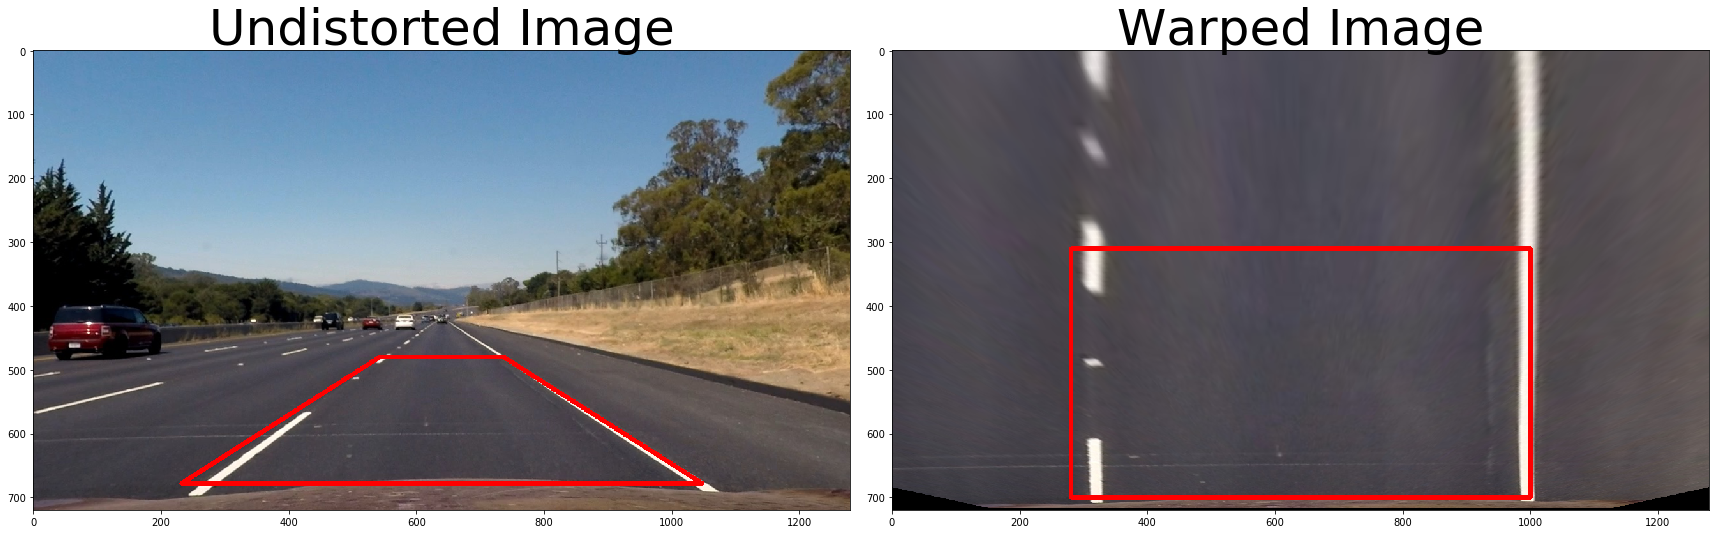

In [6]:
#Compute direct and inverse perspective transforms
src = np.float32([[232, 678], [543, 480], [737, 480], [1048, 678]])
dst = np.float32([[280, 700], [280, 310], [1000, 310], [1000, 700]])

M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)

#function to warp image
def warp_image(img, M):
    shape = img.shape[0:2][::-1]
    return cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)


img = undistort_image(mpimg.imread('test_images/straight_lines2.jpg'))
warped = warp_image(img, M)
draw_polygon(img, src)
draw_polygon(warped, dst)
show_two_images(img, "Undistorted Image", warped, "Warped Image")

In [7]:
def find_lane_lines(binary_warped, nwindows=9, margin=100, minpix=50, debug=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = None
    if debug:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img

(720, 0)

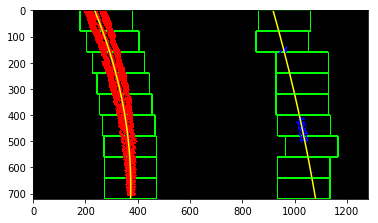

In [8]:
undist = undistort_image(mpimg.imread("test_images/test2.jpg"))
binary = pipeline(undist)
binary_warped = warp_image(binary, M)

left_fit, right_fit, out_img = find_lane_lines(binary_warped, debug=True)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [9]:
def find_lane_lines_fast(binary_warped, left_fit, right_fit, debug=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    debug_image = None
    if debug:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        debug_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
    
    return left_fit, right_fit, debug_image

(720, 0)

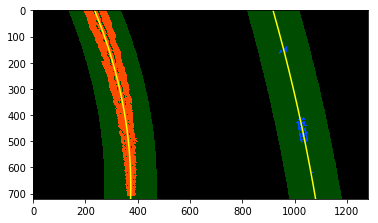

In [10]:
left_fit, right_fit, debug_image = find_lane_lines_fast(binary_warped, left_fit, right_fit, True)

plt.imshow(debug_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [11]:
def lane_curvature(fit_line, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Generate x and y values for plotting
    points_y = np.linspace(0, y_eval - 1, y_eval)
    points_x = fit_line[0] * points_y ** 2 + fit_line[1] * ploty + fit_line[2]

    fit_line_new = np.polyfit(points_y * ym_per_pix, points_x * xm_per_pix, 2)
    curvature = ((1 + (2 * fit_line_new[0] * y_eval * ym_per_pix + fit_line_new[1])**2)**1.5) / np.absolute(2*fit_line_new[0])
    return curvature

print(lane_curvature(left_fit, binary_warped.shape[0]))
print(lane_curvature(right_fit, binary_warped.shape[0]))
curvature = min(lane_curvature(left_fit, binary_warped.shape[0]),
                lane_curvature(right_fit, binary_warped.shape[0]))

538.511905189
2087.20317786


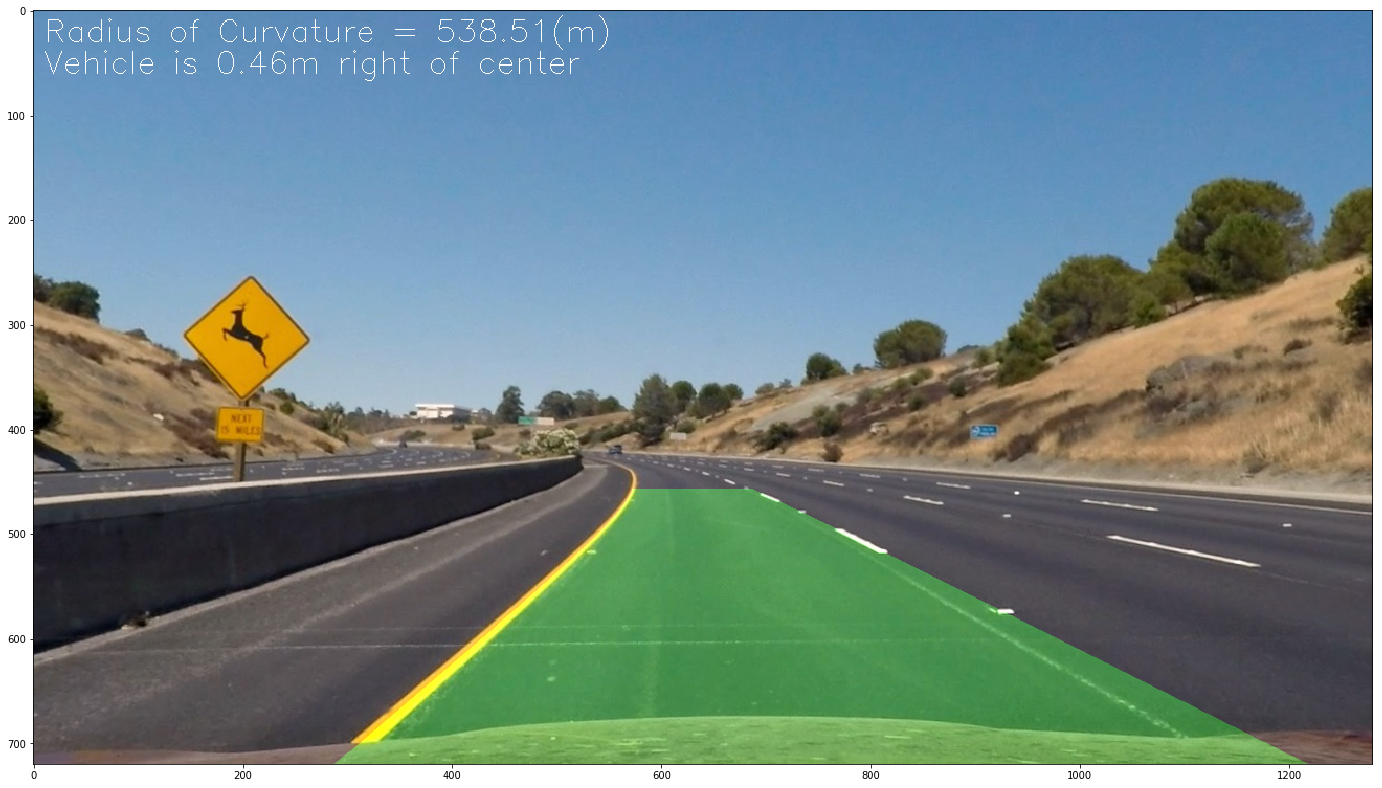

In [19]:
%matplotlib inline
def draw_lanes_info(image, left_fit, right_fit, curvature):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp_image(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    text = "Radius of Curvature = {0:.2f}(m)".format(curvature)
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (10, 30), fontFace, 1, (255,255,255))
    vehicle_positioin = (left_fitx[-1] + right_fitx[-1]) / 2.0
    vehicle_offset = vehicle_positioin - image.shape[1] / 2.0
    vehicle_offset *= 3.7/700
    text = "Vehicle is {0:.2f}m {1} of center".format(abs(vehicle_offset), "right" if vehicle_offset > 0 else "left")
    cv2.putText(result, text, (10, 60), fontFace, 1, (255,255,255))
    return result

    
#Test final_drawing
plt.figure(figsize=(24,18))
plt.imshow(draw_lanes_info(undist, left_fit, right_fit, curvature))

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

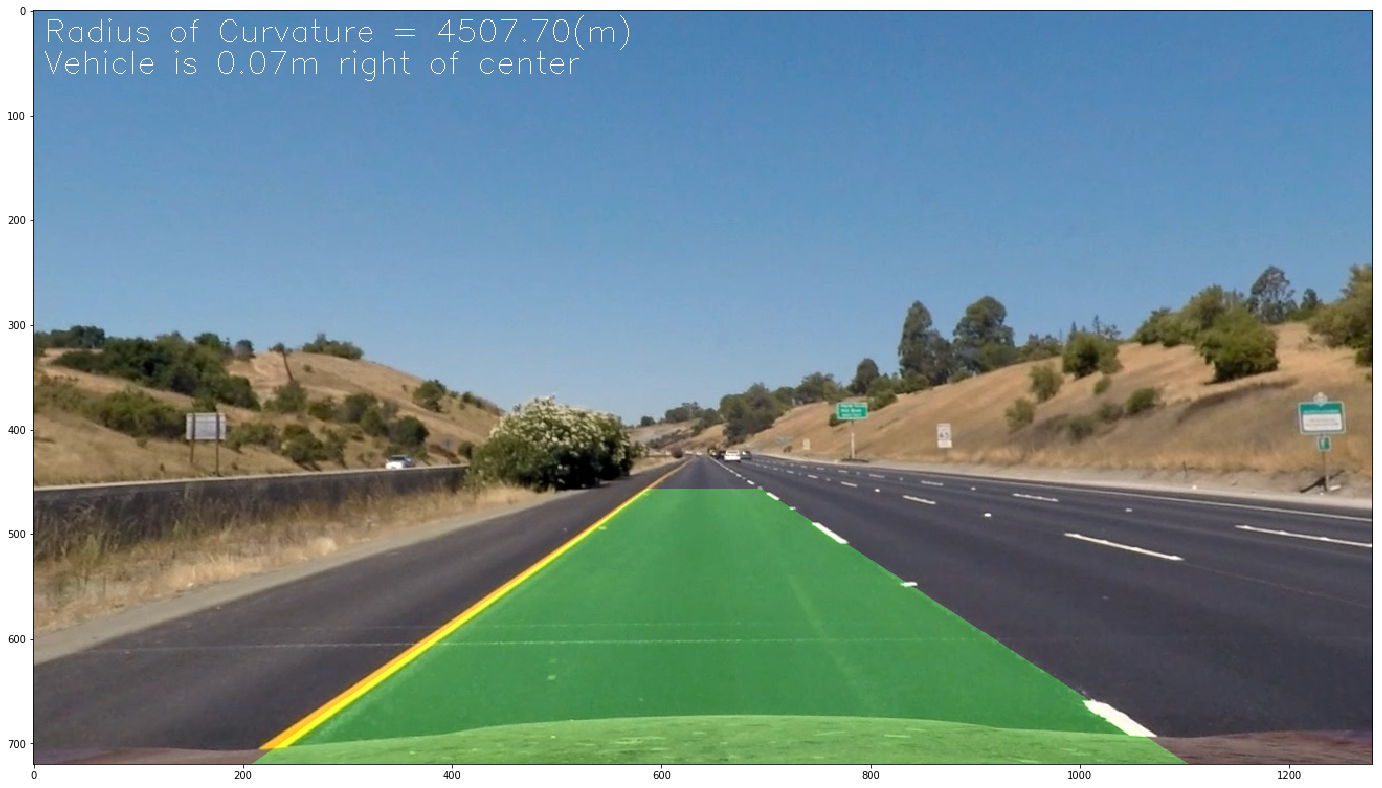

In [22]:
def process_image(image):
    undist = undistort_image(image)
    binary = pipeline(undist)
    binary_warped = warp_image(binary, M)
    left_fit, right_fit, _ = find_lane_lines(binary_warped, debug=False)
 
    curvature = min(lane_curvature(left_fit, binary_warped.shape[0]),
                lane_curvature(right_fit, binary_warped.shape[0]))
    result = draw_lanes_info(undist, left_fit, right_fit, curvature)
    return result

#Test full pipeline
image = mpimg.imread('test_images/straight_lines1.jpg')
plt.figure(figsize=(24,18))
plt.imshow(process_image(image))

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_vide.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 1/1261 [00:00<02:30,  8.36it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file test_videos_output/solidWhiteRight.mp4:

 b'test_videos_output/solidWhiteRight.mp4: No such file or directory\n'